In [13]:
import random
from Hourbid import *
from Fibid import *
from blockbid import *
import matplotlib.pyplot as plt    
from tqdm import tqdm

In [14]:
from line_profiler import LineProfiler
from functools import wraps
 
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [15]:
BS_bids = Blockbid()[0]
BD_bids = Blockbid()[1]
HS_bids = HourBid()[0]
HD_bids = HourBid()[1]
FS_bids = Fibid()[0]
FD_bids = Fibid()[1]

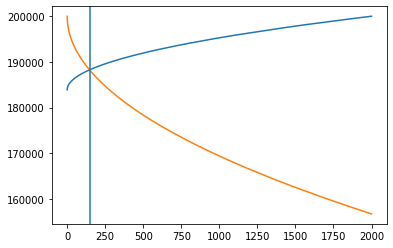

In [16]:
x = HS_bids['price'][0:1000]
y= HS_bids['Quantity'][0:1000]
x2 = HD_bids['price'][0:1000]
y2= HD_bids['Quantity'][0:1000]
plt.plot(x,y)
plt.plot(x2,y2)
plt.axvline(147)

In [17]:
HD_bids

,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,12,1000,1,S,156716.0,2000.00,1,NaN
1,12,999,1,S,156751.0,1996.76,1,NaN
2,12,998,1,S,156767.0,1995.25,1,NaN
3,12,997,1,S,156794.0,1992.78,1,NaN
4,12,996,1,S,156822.0,1990.18,1,NaN
...,...,...,...,...,...,...,...,...
23995,242,5,24,S,199186.0,6.50,1,NaN
23996,242,4,24,S,199270.0,5.22,1,NaN
23997,242,3,24,S,199466.0,2.79,1,NaN
23998,242,2,24,S,199637.0,1.29,1,NaN


In [18]:
HS_bids['Quantity'][0]-HD_bids['Quantity'][1000]

-7861.0

In [19]:
def Pairs(postion,Hour,DF,QP):
    
    if QP == 'DQ':
        DF=DF.iloc[HIndex_D[Hour][0]:HIndex_D[Hour][1]+1]
        return [DF['Quantity'][postion+HIndex_D[Hour][0]],DF['Quantity'][postion+1+HIndex_D[Hour][0]]]
    if QP == 'SQ':
        DF=DF.iloc[HIndex_S[Hour][0]:HIndex_S[Hour][1]+1]
        return [DF['Quantity'][postion+HIndex_S[Hour][0]],DF['Quantity'][postion+1+HIndex_S[Hour][0]]]
    if QP == 'DP':
        DF=DF.iloc[HIndex_D[Hour][0]:HIndex_D[Hour][1]+1]
        return [DF['price'][postion+HIndex_D[Hour][0]],DF['price'][postion+1+HIndex_D[Hour][0]]]
    else:
        DF=DF.iloc[HIndex_S[Hour][0]:HIndex_S[Hour][1]+1]
        return [DF['price'][postion+HIndex_S[Hour][0]],DF['price'][postion+1+HIndex_S[Hour][0]]]
    
Delta_S = np.zeros([len(BS_bids),24])


Delta_D = np.zeros([len(BD_bids),24])
BD_bids  = Blockbid()[1]
for i in range (len(BD_bids)):
    if BD_bids['Hour'][i]+BD_bids['Duration'][i]<=25:
        Delta_D[i,BD_bids['Hour'][i]-1:(BD_bids['Hour'][i]+BD_bids['Duration'][i])-1] = 1

BS_bids = Blockbid()[0]
for i in range (len(BS_bids)):
    if BS_bids['Hour'][i]+BS_bids['Duration'][i]<=25:
        Delta_S[i,BS_bids['Hour'][i]-1:(BS_bids['Hour'][i]+BS_bids['Duration'][i])-1] = 1

In [20]:
# Heuristic Algorithm for flexible bids
temp1 = []
for i in range(len(FS_bids)):
    temp1.append(random.randint(0,23))
    
temp2 = []
for i in range(len(FD_bids)):
    temp2.append(random.randint(0,23))
    
def HA_FB():
    for h in range(24):
        res1=[[0 for i in range(len(FS_bids))] for i in range(24)]
        res2=[[0 for i in range(len(FD_bids))] for i in range(24)]
        x1=np.where(np.array(temp1)==h)[0]
        x2=np.where(np.array(temp2)==h)[0]
        for j in x1:
            res1[h][j] = 1.0
        for k in x2:
            res2[h][k] = 1.0
    return res1,res2

In [21]:
NoneChild_D=[]
Child_D = []
Parent_D=[]
NoneChild_S=[]
Child_S=[]
Parent_S=[]
for i in range(len(BD_bids)):
    if BD_bids.isnull()['LinkID'][i] == True:
        NoneChild_D.append(i)
    else:
        Parent_D.append(np.where(BD_bids['ID']==BD_bids['LinkID'][i])[0][0])
        Child_D.append(i)
for i in range(len(BS_bids)):
    if BS_bids.isnull()['LinkID'][i] == True:
        NoneChild_S.append(i)
    else:
        Parent_S.append(np.where(BS_bids['ID']==BS_bids['LinkID'][i])[0][0])
        Child_S.append(i)

In [22]:
# Heuristic Algorithm for Block bids


def HA_B():

    BD=[ 0 for i in range(len(BD_bids))]
    BS=[ 0 for i in range(len(BS_bids))]
    for i in NoneChild_D:
        BD[i] = random.randint(0,1)
    for i in NoneChild_S:
        BS[i] = random.randint(0,1)
    return BS,BD

In [23]:
def find_f(a1,a2,b1,b2,x):
    grad = (b2-b1)/(a2-a1)
    b = b2-grad*a2
    return grad*x+b

def aggregate(h,BS,BD,FS,FD):
    
    a = 0+h*1000
    b = 1000+h*1000
    agg_q=[]
    agg_p = []
    y1=list(reversed(HD_bids['Quantity'][a:b].tolist()))
    y2=HS_bids['Quantity'][a:b].tolist()
    x1 = list(reversed(HD_bids['price'][a:b].tolist()))
    x2 = HS_bids['price'][a:b].tolist()
    
    # add Block
    for i in range(len(BS)):
        if BS[i] * Delta_S[i][h] >0:
            k = BS_bids['Quantity'][i]
            y2 = list(map(lambda x:x+k,y2))
            # for j in range(len(y2)):
            #     y2[j]=y2[j]+BS_bids['Quantity'][i]
    
    for i in range(len(BD)):
        if BD[i] * Delta_D[i][h] >0:
            k= BD_bids['Quantity'][i]
            y1 = list(map(lambda x:x+k,y1))
            # for j in range(len(y1)):
            #     y1[j]=y1[j]+BD_bids['Quantity'][i]
    # #  add Flex
    for i in range(len(FS[h])):
        if FS[h][i] == 1:
            k = FS_bids['Quantity'][i]
            y2 = list(map(lambda x:x+k,y2))
    for i in range(len(FD[h])):
        if FD[h][i] ==1:
            k = FD_bids['Quantity'][i]
            y1 = list(map(lambda x:x+k,y1))

    
    for i in range(1000):
        if x1[i]==x2[i]:
            agg_q.append(y1[i]-y2[i])
            agg_p.append(x1[i])
        elif x1[i]<x2[i]:
            temp = find_f(x2[i-1],x2[i],y2[i-1],y2[i],x1[i])
            agg_q.append(y1[i]-temp)
            agg_p.append(x1[i])
            temp = find_f(x1[i],x1[i+1],y1[i],y1[i+1],x2[i])
            agg_q.append(temp-y2[i])
            agg_p.append(x2[i])
        elif x2[i]<x1[i]:
            temp = find_f(x1[i-1],x1[i],y1[i-1],y1[i],x2[i])
            agg_q.append(temp-y2[i])
            agg_p.append(x2[i])
            temp = find_f(x2[i],x2[i+1],y2[i],y2[i+1],x1[i])
            agg_q.append(y1[i]-temp)
            agg_p.append(x1[i])
    # while agg_q[0]*agg_q[-1]>=0:
    #     raise Exception("no root")
    for i in range(len(agg_q)-1):
        if agg_q[i]*agg_q[i+1] <0:
            grad = (agg_q[i+1]-agg_q[i])/(agg_p[i+1]-agg_p[i])
            b= agg_q[i+1] - agg_p[i+1]*grad
            Res = -b/grad          
            return Res
        

$$\left[[HS][HD][FS][FD][BS][BD] \right]$$

In [24]:

def generate_population():
    restart = True
    while restart:
        restart = False
        population = [[] for i in range(4)]
        BS,BD = HA_B()
        FS,FD = HA_FB()
        
        
        population[2]=FS
        population[3]=FD
        
        population.append(BS)
        population.append(BD)
        
        HS = [np.zeros(999).tolist() for i in range(24)]
        HD = [np.zeros(999).tolist() for i in range(24)]
        
        for h in range(24):
            price = aggregate(h,BS,BD,FS,FD)
            if price == None:
                # print('regenerate')
                restart = True
                break
            BS_INT = np.where(HS_bids['price'][h*1000:1000+h*1000]>price)[0][0]
            breakpoint_S = BS_INT + (price-HS_bids['price'][BS_INT-1+1000*h])/abs((HS_bids['price'][BS_INT+1000*h]-HS_bids['price'][BS_INT-1+1000*h]))-1
            
            BD_INT = np.where(HD_bids['price'][h*1000:1000+h*1000]>price)[0][-1]
            breakpoint_D = BD_INT + 1-(price-HD_bids['price'][BD_INT+1+1000*h])/abs((HD_bids['price'][BD_INT+1000*h]-HD_bids['price'][BD_INT+1+1000*h]))
            
            HS[h][0:int(breakpoint_S)]=np.ones(int(breakpoint_S))
            HS[h][int(breakpoint_S)]=breakpoint_S-int(breakpoint_S)
            
            HD[h][0:int(breakpoint_D)]=np.ones(int(breakpoint_D))
            HD[h][int(breakpoint_D)]=breakpoint_D-int(breakpoint_D)
            
        population[0] = HS
        population[1] = HD
        
    return population

In [25]:
def fit(population):
    Error = False
    #objective value 
    gamma = 100000
    Hour_S = population[0]
    Hour_D = population[1]
    Block_S = population[4]
    Block_D = population[5]
    Flex_S = population[2]
    Flex_D = population[3]
    
    
    Res_HD = sum(0.5*(2*HD_bids['price'][1000*i+j]+Hour_D[i][j]*(HD_bids['price'][1000*i+j+1]-HD_bids['price'][1000*i+j]))*Hour_D[i][j]*(HD_bids['Quantity'][1000*i+j+1]-HD_bids['Quantity'][1000*i+j]) for j in range(999) for i in range(24))                
    Res_HS = sum(0.5*(2*HS_bids['price'][1000*i+j]+Hour_S[i][j]*(HS_bids['price'][1000*i+j+1]-HS_bids['price'][1000*i+j]))*Hour_S[i][j]*(HS_bids['Quantity'][1000*i+j+1]-HS_bids['Quantity'][1000*i+j]) for j in range(999) for i in range(24))  
     
    Res_BD = sum(BD_bids['Duration'][i]*BD_bids['Quantity'][i]*BD_bids['price'][i]*Block_D[i] for i in range(len(Block_D))) 
    Res_BS =  sum(BS_bids['Duration'][i]*BS_bids['Quantity'][i]*BS_bids['price'][i]*Block_S[i] for i in range(len(Block_S)))
    
    Res_FD = sum(FD_bids['Quantity'][i]*FD_bids['price'][i] *sum(Flex_D[h][i] for h in range(24)) for i in range(len(FD_bids))) 
    Res_FS = sum(FS_bids['Quantity'][i]*FS_bids['price'][i] *sum(Flex_S[h][i] for h in range(24)) for i in range(len(FS_bids)))
    
    BA = sum(Pair(1,h,HD_bids,'DQ')[0]-Pair(1,h,HD_bids,'DP')[0] for h in range(24))
    OBJ_V = Res_HD - Res_HS + Res_BD - Res_BS + Res_FD - Res_FS + BA
    
    for i in Child_D:
        if Block_D[i]== 1:
            if Parent_D[i]!=1:
                print(' Parent check fail')
                Error = True
    for i in Child_S:
        if Block_S[i]== 1:
            if Parent_S[i]!=1:
                print('Parent check fail')
                Error = True
                break
    
  
    # penalty by constarint
    Penalty = 0
    #  # penalty for constraint 6-7    
    for h in range(24):
        x = sum((HS_bids['price'][1000*h+j+1]-HS_bids['price'][1000*h+j]) * Hour_S[h][j] for j in range(len(Hour_S[h])-1))
        y = 2000+sum((HD_bids['price'][1000*h+j+1]-HD_bids['price'][1000*h+j]) * Hour_D[h][j] for j in range(len(Hour_D[h])-1))
        for i in range(len(FS_bids)):
            if x - FS_bids['price'][i] > gamma * Flex_S[h][i]:
                Error = True
                break
        for i in range(len(FD_bids)):
            if FD_bids['price'][i]-x < gamma * Flex_D[h][i]:
                Error = True
                break        
        if round(x,5) == round(y,5):
            Error=False
        else:
            Error=True
    return OBJ_V,Error

In [26]:
BS,BD = HA_B()
FS,FD = HA_FB()
for i in range(24):
    print(aggregate(i,BS,BD,FS,FD))

170.0092488554796
1499.1494091874665
1035.3762317728313
379.5336173136381
716.0122389558235
653.8793352192363
1437.3209679334916
624.9396689895467
490.80839270047375
352.40861150070106
397.2512637472512
579.3402860752642
10.738681732580105
470.4775647668392
705.5897347831855
514.7861253263704
895.98850035791
503.2303816793895
952.248679835713
760.9985253780334
750.2754928303253
16.09618375536178
141.67999999999984
567.1310306406683


In [27]:
Sol_set= []
for i in tqdm(range(100),ncols=5):
    Sol_set.append(generate_population())

100%|█| 100/100 [00:30<00:00,  3.29it/s]


In [28]:
value =[0,0]
for i in tqdm(range(100),ncols=10):
    Sol_set[i].append(fit(Sol_set[i])[0])

  6%| | 6/100 [00:16<04:29,  2.87s/it]

KeyboardInterrupt: 

In [ ]:
x = list(np.arange(20))
y = list(np.zeros(20))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
def select(List1,List2,SLD_size):
    begin = random.randint(SLD_size,len(List1)-SLD_size)
    temp =List1[begin:begin+SLD_size] 
    List1[begin:begin+SLD_size]=List2[begin:begin+SLD_size]
    List2[begin:begin+SLD_size] = temp
    return List1,List2



In [ ]:
select(x,y,4)

([0,
  1,
  2,
  3,
  0.0,
  5,
  6,
  7,
  0.0,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  4,
  0.0,
  0.0,
  0.0,
  8,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  16,
  17,
  18,
  19])

In [ ]:

%lprun -T lprof0 -f select 
print(open('lprof0', 'r').read())


*** Profile printout saved to text file 'lprof0'. 
Timer unit: 1e-07 s

Total time: 2.25e-05 s
File: <ipython-input-178-c9e37017f968>
Function: select at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def select(List1,List2,SLD_size):
     2         1        201.0    201.0     89.3      begin = random.randint(SLD_size,len(List1)-SLD_size)
     3         1         10.0     10.0      4.4      temp =List1[begin:begin+SLD_size] 
     4         1          9.0      9.0      4.0      List1[begin:begin+SLD_size]=List2[begin:begin+SLD_size]
     5         1          3.0      3.0      1.3      List2[begin:begin+SLD_size] = temp
     6         1          2.0      2.0      0.9      return List1,List2


Timer unit: 1e-07 s

Total time: 2.25e-05 s
File: <ipython-input-178-c9e37017f968>
Function: select at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def select(List1,List2,SLD_size):
     2         1        201.0    201.0     89.3      begin = random.randint(SLD_size,len(List1)-SLD_size)
     3         1         10.0     10.0      4.4      temp =List1[begin:begin+SLD_size] 
     4         1          9.0      9.0      4.0      List1[begin:begin+SLD_size]=List2[begin:begin+SLD_size]
     5         1          3.0      3.0      1.3      List2[begin:begin+SLD_size] = temp
     6         1          2.0      2.0      0.9      return List1,List2